In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [284]:
def make_block_generator(array, block_width, block_height):
    '''
    Makes a generator which yields blocks of size block_width x
    block_height.

    At the moment, this should ignore elements on the edge of
    arrays which are not evenly divided by block_widht/height.
    '''
    width, height = array.shape[:2]
    for x in range(0, width - block_width, block_width):
        for y in range(0, height - block_height, block_height):
            yield array[x:x + block_width, y:y+block_height]
            
def makeZeroPadder(bitsPerColor):
    def zeroPad(binary):
        assert len(binary) <= bitsPerColor
        diff = bitsPerColor - len(binary)
        return diff*'0' + binary
    return zeroPad
zero_padder = makeZeroPadder(8)

In [395]:
def dct_encode(image, text, channel = 1, intensity = 30):
    '''                                                                                                                                                                                                                                       
    Uses discrete cosine transform to encode text in coefficents of
    image.

    1. Break the image up into 8x8 blocks.
    2. Perform the DCT on each block.
    3. For each block, compare the coefficents in positions (6, 7) and
       (5, 1).
        - If (6, 7) > (5, 1) the encoded bit is a 1.
        - Otherwise, the encoded bit is a zero.
    4. Swap the coefficents to properly encode the value needed.

    @param image cv2 image to encode text into.
    @param text ascii text to encode into image.
    @param the channel to encode the text into, R, G, or B.
    @return a new image with the ecoded text.
    
    TODO(zeke): This function needs repition and a way to indicate the
    length of the encoded string.
    '''                                                                                                                                                                                                    
    if ( channel > 4 ):
        print("WARNING: Channel is {}. This is probably a mistake.".format(channel))
        print("         Color images typically only have three channels: R, G and B.")

    # The width and height of the blocks that we will perform the DCT                                                                                                                                                                         
    # on. The choice of 8 here is more or less standard across JPEG                                                                                                                                                                           
    # compression as far as I know.       
    block_width = 8
    block_height = 8

    width, height, _ = image.shape
    grid_width = width / block_width
    grid_height = height / block_height

    # Split image into channels. For a color image this is R, G, B.                                                                                                                                                                         
    channels = cv2.split(image)
    the_channel = channels[channel]
    
    # Convert the text to binary enforcing that its ascii only.
    bintext = ''.join([zero_padder(bin(c)[2:]) for c in bytearray(text, 'ascii')])
    text = iter(bintext)
    
    # Transform into frequency domain and swap bits as needed.
    for block in make_block_generator(the_channel, block_width, block_height):
        db = cv2.dct(block)
        a = db[6, 7]
        b = db[5, 1]

        c = next(text, None)
        if not c:
            text = iter(bintext)
            c = next(text, None)
        
        if c == '1':
            if ( a < b ):
                a, b = b, a
        if c == '0':
            if a > b:
                a, b = b, a

        # We add an intensity constant to boost the diff between
        # the two coefficents.
        if a > b:
            d = (intensity - (a - b))/2
            a += d
            b -= d
        elif a < b:
            d = (intensity - (b - a))/2
            a -= d
            b += d
        # In the a == b case we just want to nudge them in the right
        # direction. Not doing this will lead to bad decoding.
        elif a == b:
            if c == '1':
                a += intensity / 2
                b -= intensity / 2
            if c == '0':
                b += intensity / 2
                a -= intensity / 2
                
        db[6, 7] = a
        db[5, 1] = b
        block[:, :] = cv2.idct(db)
            
    # Stack channels back together.
    channels[channel] = the_channel
    
    # Normalize values.
    return np.dstack(channels)

In [396]:
def dct_decode(image, channel = 1):
    '''
    Recovers a message from the channels of the DCT of an image.
    
    1. Break the image up into 8x8 blocks.
    2. Perform the DCT on each block.
    3. For each block, compare the coefficents in positions (6, 7) and
       (5, 1).
        - If (6, 7) > (5, 1) the encoded bit is a 1.
        - Otherwise, the encoded bit is a zero.
    4. Swap the coefficents to properly encode the value needed.
    '''
    if ( channel > 4 ):
        print("WARNING: Channel is {}. This is probably a mistake.".format(channel))
        print("         Color images typically only have three channels: R, G and B.")

    # The width and height of the blocks that we will perform the DCT                                                                                                                                                                         
    # on. The choice of 8 here is more or less standard across JPEG                                                                                                                                                                           
    # compression as far as I know.       
    block_width = 8
    block_height = 8

    width, height, _ = image.shape
    grid_width = width / block_width
    grid_height = height / block_height

    # Split image into channels. For a color image this is R, G, B.                                                                                                                                                                         
    channels = cv2.split(image)
    the_channel = channels[channel]
    
    text = ''
    # Transform into frequency domain and swap bits as needed.
    for block in make_block_generator(the_channel, block_width, block_height):
        db = cv2.dct(block)
        a = db[6, 7]
        b = db[5, 1]
        
        if a <= b:
            text += '0'
        else:
            text += '1'
    
    # Convert text into string.
    # Break into 8 bit chunks
    chunks = [text[x:x + 8] for x in range(0, len(text), 8)]
    
    return ''.join([chr(int(c, 2)) for c in chunks])

In [397]:
filepath = "imgs/pooh.jpeg"
image = np.float32(cv2.imread(filepath))
encoded = dct_encode(image, "I love dogs!!")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

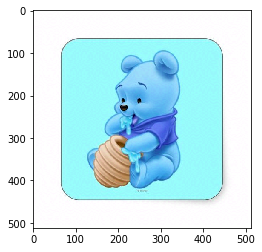

In [400]:
plt.imshow(encoded / 255)
cv2.imwrite("imgs/pooh_encoded.jpeg", encoded)

In [401]:
dct_decode(np.float32(cv2.imread("imgs/pooh_encoded.jpeg")))

"I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I lo~e dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I love do's!!I love dogs!!I lova dog\x7f!!I love dogs!!I love dogs!!I love dogs!!I love dogs!!I \x00"